In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
df <- read.csv("/content/drive/My Drive/Data/students_habit_study_hours.csv")
df <- df[ , -1]

In [1]:
install.packages("caret")
install.packages("randomForest")
install.packages("gbm")
install.packages("e1071")  # required by caret
library(caret)
library(randomForest)
library(gbm)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: ggplot2

Loading required package: lattice

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Loaded gbm 2.2.2

This version of gbm is no longer under development. Consider tran

In [12]:
search_best_rfe_model <- function(df, target_col = "study_hours_per_day", max_features = 15) {
  if (!(target_col %in% colnames(df))) {
    stop("Target column not found.")
  }

  # Define control for RFE
  ctrl <- rfeControl(functions = rfFuncs,  # default to random forest, switch per model
                     method = "cv",
                     number = 5,
                     verbose = FALSE)

  models <- list(
    "Linear Regression" = list(
      method = "lm",
      funcs = lmFuncs,
      tuneGrid = NULL
    ),
    "Decision Tree" = list(
      method = "rpart",
      funcs = caretFuncs,
      tuneGrid = expand.grid(cp = c(0.01, 0.05, 0.1))
    ),
    "Random Forest" = list(
      method = "rf",
      funcs = rfFuncs,
      tuneGrid = expand.grid(mtry = 2:5)
    ),
    "Gradient Boosting" = list(
      method = "gbm",
      funcs = caretFuncs,
      tuneGrid = expand.grid(
        n.trees = c(50, 100),
        interaction.depth = c(1, 3, 5),
        shrinkage = c(0.05, 0.1),
        n.minobsinnode = 10
      )
    )
  )

  results <- list()

  for (model_name in names(models)) {
    cat("\nSearching best RFE + GridSearchCV for", model_name, "...\n")

    model_info <- models[[model_name]]
    x <- df[, !(colnames(df) %in% target_col)]
    y <- df[[target_col]]

    # Apply RFE with tuning
    set.seed(42)
    rfe_result <- rfe(
      x = x,
      y = y,
      sizes = 1:min(ncol(x), max_features),
      rfeControl = rfeControl(functions = model_info$funcs, method = "cv", number = 5),
      method = model_info$method,
      tuneGrid = model_info$tuneGrid
    )

    best_features <- predictors(rfe_result)
    best_perf <- rfe_result$results[which.max(rfe_result$results$Rsquared), ]

    results[[model_name]] <- data.frame(
      Model = model_name,
      Best_Num_Features = length(best_features),
      Best_MSE = best_perf$RMSE^2,
      Best_R2 = best_perf$Rsquared,
      Selected_Features = paste(best_features, collapse = ", ")
    )
  }

  return(do.call(rbind, results))
}
results_df <- search_best_rfe_model(df)
print(results_df)

Streaming output truncated to the last 5000 lines.
     8        1.4684            -nan     0.0500    0.0818
     9        1.3943            -nan     0.0500    0.0679
    10        1.3290            -nan     0.0500    0.0635
    20        0.9300            -nan     0.0500    0.0246
    40        0.7191            -nan     0.0500    0.0031
    60        0.6762            -nan     0.0500   -0.0002
    80        0.6554            -nan     0.0500   -0.0017
   100        0.6419            -nan     0.0500   -0.0010

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        2.2077            -nan     0.1000    0.1946
     2        2.0405            -nan     0.1000    0.1658
     3        1.9013            -nan     0.1000    0.1412
     4        1.7803            -nan     0.1000    0.1213
     5        1.6621            -nan     0.1000    0.0998
     6        1.5633            -nan     0.1000    0.0951
     7        1.4764            -nan     0.1000    0.0727
     8        1.3991

In [3]:
install.packages("ggplot2")
library(ggplot2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [31]:
plot_r2_bar <- function(results_df) {
  colors <- c("skyblue", "lightgreen", "salmon", "gold", "orchid", "lightcoral", "plum")
  model_colors <- colors[1:nrow(results_df)]

  ggplot(results_df, aes(x = Model, y = Best_R2, fill = Model)) +
    geom_bar(stat = "identity", color = "black", width = 0.6) +
    geom_text(aes(label = round(Best_R2, 3)), vjust = -0.5, size = 4) +
    scale_fill_manual(values = model_colors) +
    scale_y_continuous(limits = c(0, 1), expand = expansion(mult = c(0, 0.05))) +
    labs(title = "R² Score by Model (Best RFE Configuration)", y = "Best R² Score", x = "") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 15, hjust = 1, size = 14),
    legend.position = "none",
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    axis.line = element_line(color = "black", size = 0.8))
}

In [38]:
plot_mse_bar <- function(results_df) {
  colors <- c("skyblue", "lightgreen", "salmon", "gold", "orchid", "lightcoral", "plum")
  model_colors <- colors[1:nrow(results_df)]

  ggplot(results_df, aes(x = Model, y = Best_MSE, fill = Model)) +
    geom_bar(stat = "identity", color = "black", width = 0.6) +
    geom_text(aes(label = round(Best_MSE, 3)), vjust = -0.5, size = 4) +
    scale_fill_manual(values = model_colors) +
    scale_y_continuous(limits = c(0, 1), expand = expansion(mult = c(0, 0.05))) +
    labs(title = "MSE by Model (Best RFE Configuration)", y = "Best Mean Squared Error", x = "") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 15, hjust = 1, size = 14),
    legend.position = "none",
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    axis.line = element_line(color = "black", size = 0.8))
}

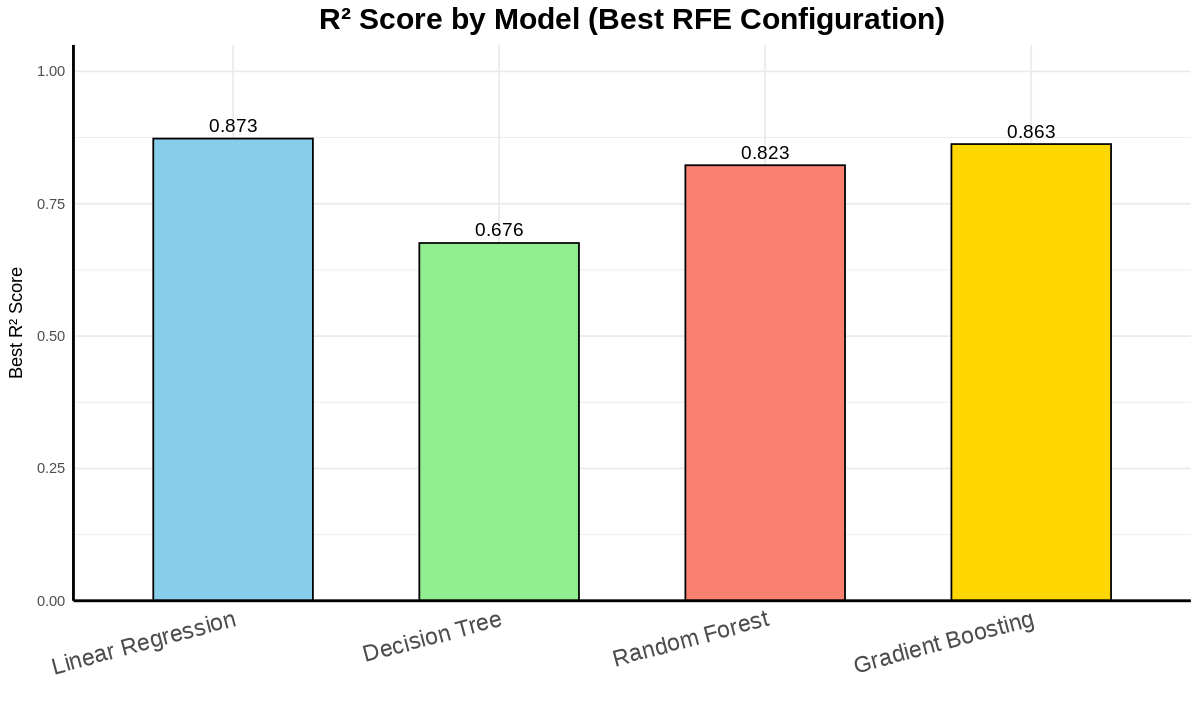

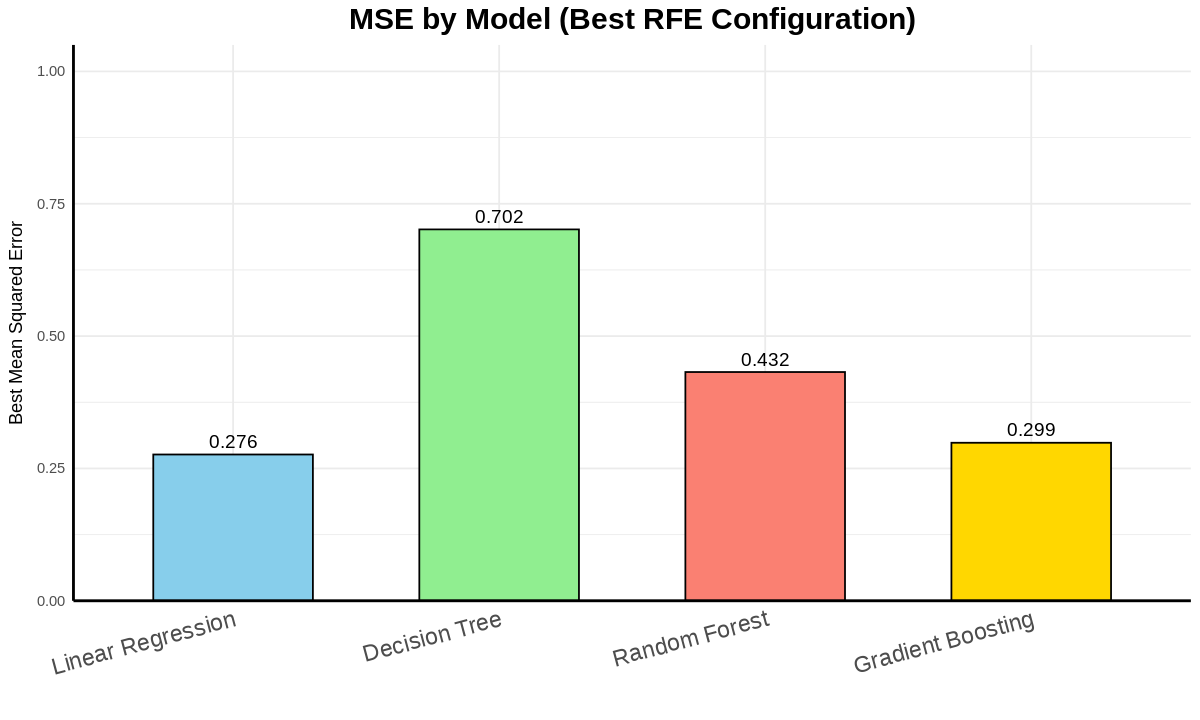

In [39]:
options(repr.plot.width = 10, repr.plot.height = 6)
results_df$Model <- factor(results_df$Model, levels = c(
  "Linear Regression",
  "Decision Tree",
  "Random Forest",
  "Gradient Boosting"
))
plot_r2_bar(results_df)
plot_mse_bar(results_df)